### This script is used to determine which parameters are included in the deeplearning model
### Additionally, it provides options to generate the synthetic dataset

In [6]:
import pandas as pd
import numpy as np
from pvlib import location, irradiance, temperature, pvsystem,solarposition
import matplotlib.pyplot as plt
from random import seed
from itertools import product
from sandiapv_energy_prediction import *
from scipy.integrate import trapezoid
from scipy.stats import truncnorm

## sensitivity study

Define the desired pv_system options to be analyzed for the sensitivity study. Two options are provided; synthetic panels resembling true outputs and just fake options

In [7]:
def get_pv_system(panel):
    """ Retrieves and configures a PVSystem object based on the panel type and parameters. """

    # module_specs = {
    # 'monocrystalline': {'pdc0': 250, 'gamma_pdc': -0.35},
    # 'polycrystalline': {'pdc0': 220, 'gamma_pdc': -0.35},
    #  'thin-film': {'pdc0': 200, 'gamma_pdc': -0.35},
    #  'bifacial': {'pdc0': 170, 'gamma_pdc': -0.35}    
    # } 

    module_specs = {
    'panel 1a': {'pdc0': 300, 'gamma_pdc': -0.005},
    'panel 2a ': {'pdc0': 275, 'gamma_pdc': -0.005},
    'panel 3a': {'pdc0': 250, 'gamma_pdc': -0.005},
    'panel 4a': {'pdc0': 225, 'gamma_pdc': -0.005},
    'panel 4b': {'pdc0': 225, 'gamma_pdc': -0.002},
    } 
    
    module_parameters = module_specs[panel['module_type']]
    mount = pvsystem.FixedMount(panel['tilt'], panel['azimuth'],)

    # Define inverter parameters
    inverter_parameters = {'pdc0': 250, 'eta_inv_nom': 0.95}

    # Create a PVSystem object
    array_one = (pvsystem.Array( mount=mount, 
                                module_parameters=module_parameters,
                                temperature_model_parameters= panel['temperature']
                                ))
    return pvsystem.PVSystem(name = 'system1',
                            arrays =array_one,
                            inverter =inverter_parameters,                           
                            )

def simulate_pv_output(system, weather_data, location):
    """ Simulate daily PV output for all arrays in the system. """
    #solar_position = location.get_solarposition(weather_data.index)
    solar_position = location.get_solarposition(weather_data.index, location.latitude, location.longitude)

    # Extract relevant weather data
    temp_air = weather_data['temp_air']
    wind_speed = weather_data['wind_speed']
    
    # Initialize an empty DataFrame to store the output for each array
    output_data = pd.DataFrame(index=weather_data.index)
    
    # Simulate output for each array in the system
    for array in system.arrays:
        poa_irrad = irradiance.get_total_irradiance(array.mount.surface_tilt, array.mount.surface_azimuth,
                                                    solar_position['apparent_zenith'], solar_position['azimuth'],
                                                    weather_data['dni'], weather_data['temp_air'], weather_data['dhi'])
        # Calculate cell temperature
        cell_temperature = temperature.sapm_cell(poa_irrad['poa_global'], temp_air, wind_speed,
                                                  **array.temperature_model_parameters)
        
        # Create a PVSystem object with a single array
        single_array_system = pvsystem.PVSystem(
                             name=system.name,
                            arrays=[system.arrays[0]],
                            inverter=system.inverter,)
        
        # Calculate DC output for the current array
        dc_output = single_array_system.pvwatts_dc(poa_irrad['poa_global'], cell_temperature)
        
        # Store the DC output in the output_data DataFrame
        output_data[array.name] = dc_output
    
    return output_data

retrieve the weather data 

In [ ]:
weather_data =  pd.read_csv('energy_data/result.csv')

weather_data = weather_data.drop('W.mean_value',axis=1)

weather_data.index = pd.to_datetime(weather_data['time'], utc=True)
weather_data.rename(columns={'T': 'temp_air', 'FH': 'wind_speed'}, inplace=True)
weather_data.tail()

# Define location: eindhoven
latitude, longitude, tz = 51.43, 5.48, 'Europe/Amsterdam'
site_location = location.Location(latitude, longitude, tz)

# Calculate solar position
solar_position = site_location.get_solarposition(weather_data.index)

# Filter out nighttime data
weather_data_daily = weather_data[solar_position['elevation'] > 0]

# Now you can check the filtered dataset
print(weather_data_daily.columns)
print(weather_data_daily.shape)
print(weather_data_daily.tail())

[-61.65433515 -61.65060019 -61.64995832 ...  61.73832837  61.73887968
  61.74207716]
Index(['time', 'Q', 'temp_air', 'wind_speed', 'dni', 'dhi'], dtype='object')
(4405, 6)
                                                time           Q  temp_air  \
time                                                                         
2023-12-31 11:00:00+00:00  2023-12-31 11:00:00+00:00  116.666667       8.7   
2023-12-31 12:00:00+00:00  2023-12-31 12:00:00+00:00  136.111111       8.9   
2023-12-31 13:00:00+00:00  2023-12-31 13:00:00+00:00  113.888889       9.2   
2023-12-31 14:00:00+00:00  2023-12-31 14:00:00+00:00   30.555556       9.6   
2023-12-31 15:00:00+00:00  2023-12-31 15:00:00+00:00    5.555556       9.4   

                           wind_speed        dni         dhi  
time                                                          
2023-12-31 11:00:00+00:00        90.0  30.650095  108.786827  
2023-12-31 12:00:00+00:00        90.0  57.446371  120.914873  
2023-12-31 13:00:00+00:00    

Function to create a dataframe crossreferencing all options. note this function can take while.

In [51]:

def sensitivity_analysis(weather_data, altitude, tilt_range, azimuth_range, module_types,temperature_params):
    """ Perform a sensitivity analysis for the given parameters. """

    results = []
    # Iterate over all combinations of the given parameters and simulate the PV output
    for tilt, azimuth, module_type,temp,altitude in product(tilt_range, azimuth_range, module_types,temperature_params,altitude): 
        site_location = location.Location(latitude=51.43, longitude=5.48, altitude=altitude, tz='Europe/Amsterdam')         
        panel = {'tilt': tilt, 'azimuth': azimuth, 'module_type': module_type,'altitude':altitude,'temperature':{'a': temp[0], 'b': temp[1], 'deltaT': temp[2]} }
        system = get_pv_system(panel)
        output = simulate_pv_output(system, weather_data, site_location)
        results.append({'tilt': tilt, 'azimuth': azimuth, 'module_type': module_type,'altitude':altitude,'temperature':{'a': temp[0], 'b':temp[1], 'deltaT': temp[2]} , 'output': output.mean().mean()})
    return pd.DataFrame(results)

In [52]:
""" Perform sensitivity analysis for the given parameters. """

# Define the parameters for the sensitivity analysis
tilt_range = np.linspace(0,90, 10)  
azimuth_range = np.linspace(0, 360, 10)  
altitude = np.linspace(1,100,4)
module_types = {
    'panel 1a': {'pdc0': 300, 'gamma_pdc': -0.005},
    'panel 2a ': {'pdc0': 275, 'gamma_pdc': -0.005},
    'panel 3a': {'pdc0': 250, 'gamma_pdc': -0.005},
    'panel 4a': {'pdc0': 225, 'gamma_pdc': -0.005},
    'panel 4b': {'pdc0': 225, 'gamma_pdc': -0.002},
    } 
    
# Temperature parameters defined by pvlib library
temperature_params = [[-3.47, -0.0594, 3],[-2.98, -0.0471, 1],[-3.56, -0.075, 3],[-2.81, -0.0455, 0]] 

# Load the results from a CSV file if it exists
try:
    sa_results = pd.read('energy_data/sensitivity_analysis_results.csv')
except: 
    # Perform sensitivity analysis
    sa_results = sensitivity_analysis(weather_data_daily, altitude, tilt_range, azimuth_range, module_types,temperature_params)
    
    # Save results to CSV
    sa_results.to_csv('energy_data/sensitivity_analysis_results.csv', index=False)


In [53]:
""" Display the results of the sensitivity analysis. """
sa_results.head()

,tilt,azimuth,module_type,altitude,temperature,output
0,0.0,0.0,panel 1a,1.0,"{'a': -3.47, 'b': -0.0594, 'deltaT': 3}",77.45258
1,0.0,0.0,panel 1a,34.0,"{'a': -3.47, 'b': -0.0594, 'deltaT': 3}",77.45258
2,0.0,0.0,panel 1a,67.0,"{'a': -3.47, 'b': -0.0594, 'deltaT': 3}",77.45258
3,0.0,0.0,panel 1a,100.0,"{'a': -3.47, 'b': -0.0594, 'deltaT': 3}",77.45258
4,0.0,0.0,panel 1a,1.0,"{'a': -2.98, 'b': -0.0471, 'deltaT': 1}",76.89371


0    {'a': -3.47, 'b': -0.0594, 'deltaT': 3}
1    {'a': -2.98, 'b': -0.0471, 'deltaT': 1}
Name: temperature, dtype: object


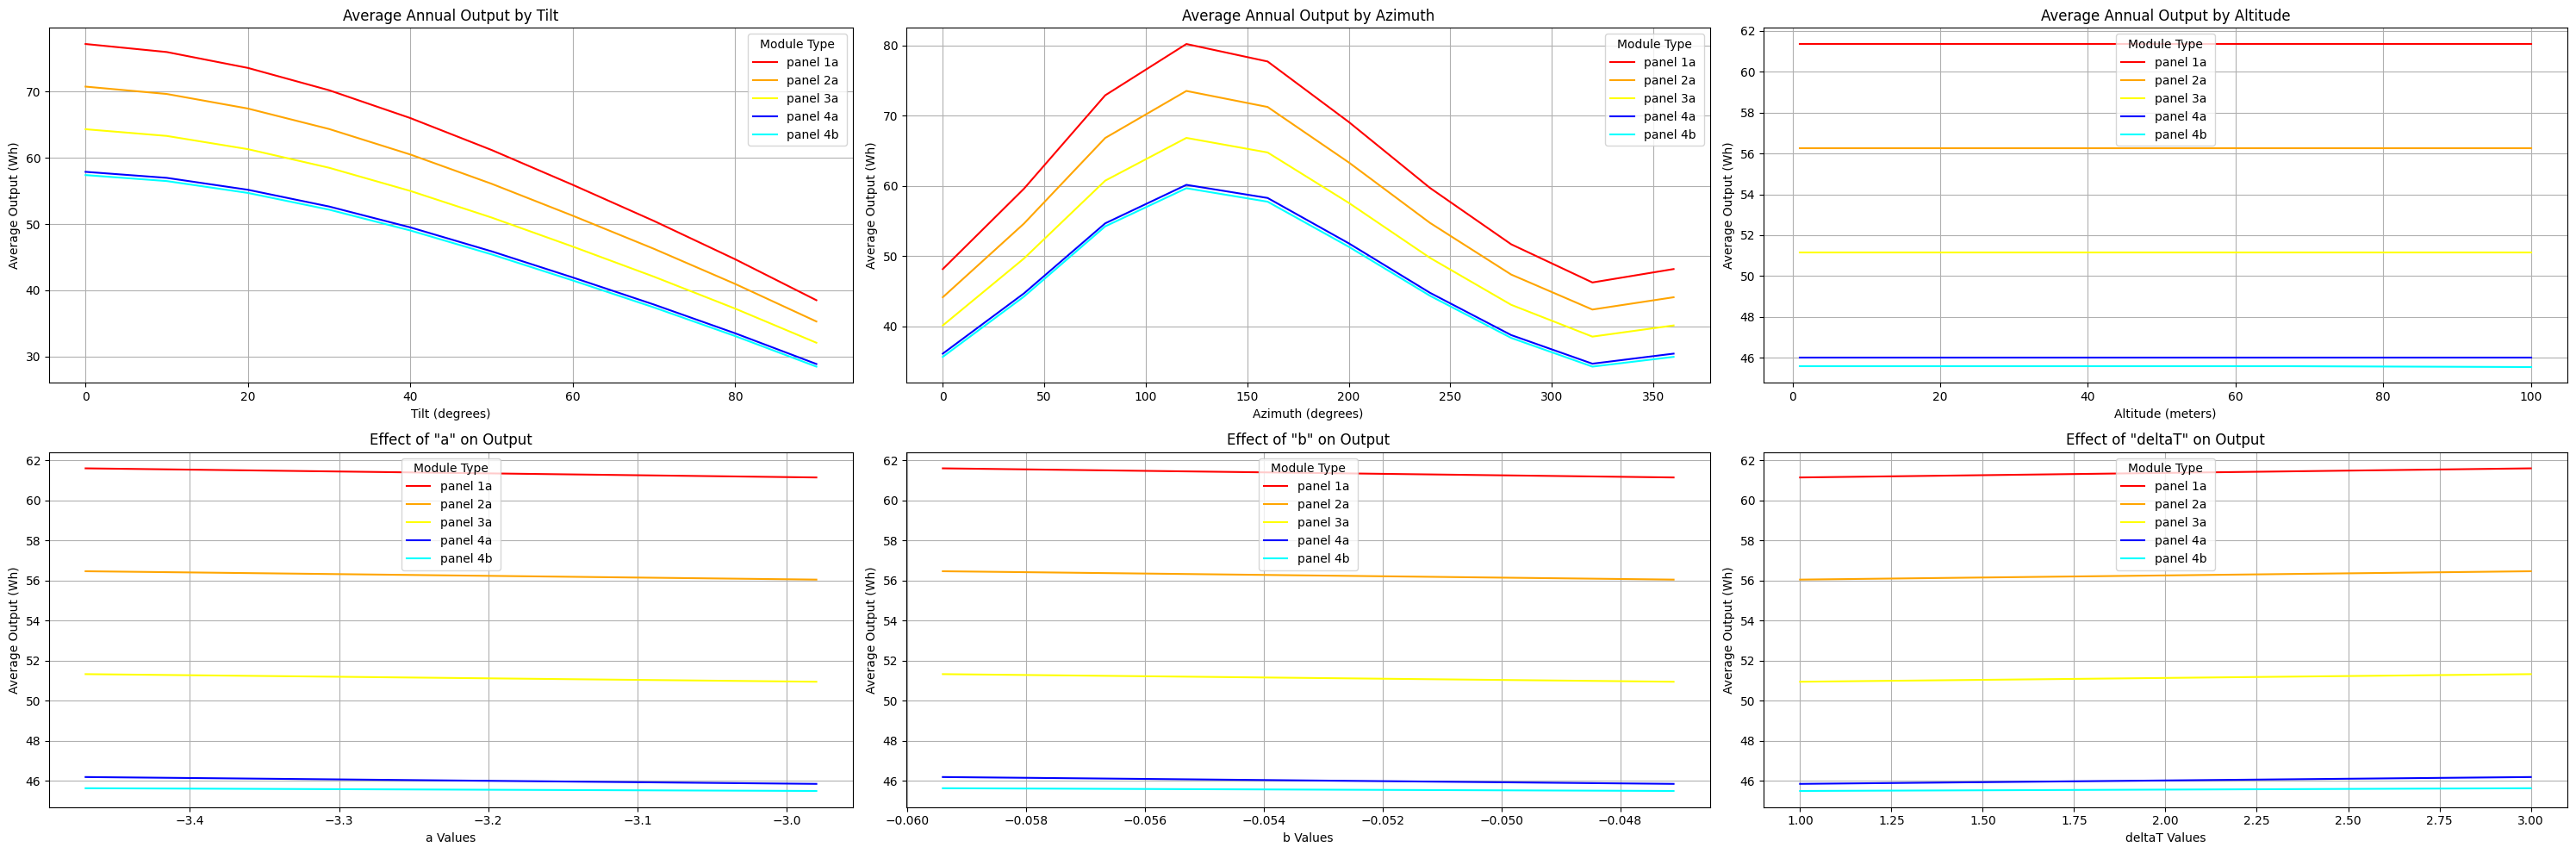

In [54]:
""" Plot the effects of the different parameters on the PV output."""
module_types ={
    'panel 1a': {'pdc0': 300, 'gamma_pdc': -0.005},
    'panel 2a ': {'pdc0': 275, 'gamma_pdc': -0.005},
    'panel 3a': {'pdc0': 250, 'gamma_pdc': -0.005},
    'panel 4a': {'pdc0': 225, 'gamma_pdc': -0.005},
    'panel 4b': {'pdc0': 225, 'gamma_pdc': -0.002},
    } 
    
# Define colors for each module type
colors = ['red', 'orange', 'yellow', 'blue'  ,'cyan','purple']  #

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 10))

# Tilt Effects Plot
for color, module_type in zip(colors, module_types):
    filtered_data = sa_results[sa_results['module_type'] == module_type]
    tilt_agg = filtered_data.groupby('tilt')['output'].mean()
    axes[0,0].plot(tilt_agg.index, tilt_agg.values, label=f'{module_type}', color=color)
axes[0,0].set_title('Average Annual Output by Tilt')
axes[0,0].set_xlabel('Tilt (degrees)')
axes[0,0].set_ylabel('Average Output (Wh)')
axes[0,0].legend(title='Module Type')
axes[0,0].grid(True)

# Azimuth Effects Plot
for color, module_type in zip(colors, module_types):
    filtered_data = sa_results[sa_results['module_type'] == module_type]
    azimuth_agg = filtered_data.groupby('azimuth')['output'].mean()
    axes[0,1].plot(azimuth_agg.index, azimuth_agg.values, label=f'{module_type}', color=color)
axes[0,1].set_title('Average Annual Output by Azimuth')
axes[0,1].set_xlabel('Azimuth (degrees)')
axes[0,1].set_ylabel('Average Output (Wh)')
axes[0,1].legend(title='Module Type')
axes[0,1].grid(True)

# Azimuth Effects Plot
for color, module_type in zip(colors, module_types):
    filtered_data = sa_results[sa_results['module_type'] == module_type]
    azimuth_agg = filtered_data.groupby('altitude')['output'].mean()
    axes[0,2].plot(azimuth_agg.index, azimuth_agg.values, label=f'{module_type}', color=color)
axes[0,2].set_title('Average Annual Output by Altitude')
axes[0,2].set_xlabel('Altitude (meters)')
axes[0,2].set_ylabel('Average Output (Wh)')
axes[0,2].legend(title='Module Type')
axes[0,2].grid(True)

# Temperature Effects Plot, now in the second row
temp_params = sa_results['temperature'].drop_duplicates().reset_index(drop=True)
temp_colors = ['red', 'blue', 'green', 'purple'][:len(temp_params)]
temp_df = sa_results['temperature'].apply(pd.Series)
sa_results_expanded = pd.concat([sa_results, temp_df], axis=1)

# Plotting the effects of each temperature parameter 'a', 'b', 'deltaT'
parameters = ['a', 'b', 'deltaT']
titles = ['Effect of "a" on Output', 'Effect of "b" on Output', 'Effect of "deltaT" on Output']
x_labels = ['a Values', 'b Values', 'deltaT Values']

# Iterate over each parameter and plot the effects of each temperature parameter
for i, param in enumerate(parameters):
    for color, module_type in zip(colors, module_types):
        # Filter data for each module type and aggregate by parameter
        filtered_data = sa_results_expanded[sa_results_expanded['module_type'] == module_type]
        param_agg = filtered_data.groupby(param)['output'].mean()
        
        axes[1,i].plot(param_agg.index, param_agg.values, label=f'{module_type}', color=color)
        axes[1,i].set_title(titles[i])
        axes[1,i].set_xlabel(x_labels[i])
        axes[1,i].set_ylabel('Average Output (Wh)')
        axes[1,i].legend(title='Module Type')
        axes[1,i].grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

## 2) Generate Synthetic dataset Dataset

In [55]:
""" Define the gaussian functions if needed. """
# # Define the Gaussian function
# def gaussian(x, a, b, c):
#     return a * np.exp(-((x - b) ** 2) / (2 * c ** 2))

# # Function to fit Gaussian to daily data
# def fit_gaussian_to_daily_data(hourly_data):
#     x_numeric = np.arange(len(hourly_data))
#     #print(hourly_data.values)
#     #hourly_data = hourly_data.values
#     #print(hourly_data)
#     #print(hourly_data)
#     try:
#         # Improved initial guesses and increase maxfev
#         p0 = [max(hourly_data), np.argmax(hourly_data), len(hourly_data) / 2]  # Better estimate of std deviation
#         popt, _ = curve_fit(gaussian, x_numeric, hourly_data, p0=p0, maxfev=1000)
#     except Exception as e:
#         #print(f"Error in Gaussian fit: {e}")
#         popt = None
#     return popt

In [56]:
def get_truncated_normal(mean, std, lower_bound, upper_bound, n_samples):
    """ Generate random samples from a truncated normal distribution. """
    a, b = (lower_bound - mean) / std, (upper_bound - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(n_samples)

def generate_dataset(days_per_pv_panel,weather_data, site_location,module_types,module_probs, temperature_params,n_samples,tilt_mean,tilt_std,azimuth_mean,azimuth_std):
    """ Generate a dataset for training the deep learning model."""

    # Initialize lists to store the results and the delta AUC values
    results = []
    delta_AUC = []
    counter = 0
    iteration =0 

    # Generate random samples for the tilt, azimuth, and module type
    tilts = get_truncated_normal(tilt_mean, tilt_std, 0, 90, n_samples)
    azimuths = get_truncated_normal(azimuth_mean, azimuth_std, 0, 360, n_samples)
    modules = np.random.choice(module_types, n_samples, p=module_probs)

    # Iterate over each sample and simulate the PV output
    for tilt, azimuth, module_type in zip(tilts, azimuths, modules):          
        panel = {'tilt': tilt, 'azimuth': azimuth, 'module_type': module_type,'temperature':{'a': temperature_params[0], 'b': temperature_params[1], 'deltaT': temperature_params[2]} }
        system = get_pv_system(panel)
        output = simulate_pv_output(system, weather_data, site_location)
        counter += 1 
        
        # Iterate over each day in the year and simulate the PV output
        start_day = np.random.randint(0,365-days_per_pv_panel)
        for day in range(days_per_pv_panel):
            iteration +=1
            start_idx = (start_day*24) + day * 24
            end_idx = (start_day*24)+ (day + 1) * 24

            daily_data = output.iloc[start_idx:end_idx]
            daily_weather_data = weather_data.iloc[start_idx:end_idx]
            
            #popt = fit_gaussian_to_daily_data(daily_data.values.flatten())
            #print(popt)
            # if popt is not None:
            # x_dense = np.linspace(0, 23, 500)  
            # gaussian_curve = gaussian(x_dense, *popt)
            
            # # Calculate the area under the Gaussian curve
            # area_gaussian = trapezoid(gaussian_curve, dx=x_dense[1]-x_dense[0])

            # # Calculate the area under the original daily mean data
            # area_original = trapezoid(daily_data, dx=1) 
            # delta_AUC.append(area_original/area_gaussian)
            #print(list(daily_data.values.flatten()))
            #Extracting hourly weather data lists
            daily_weather = {
            'temperature_sequence': list(daily_weather_data['temp_air']),
            'wind_speed_sequence': list(daily_weather_data['wind_speed']),
            'dni_sequence': list(daily_weather_data['dni']),
            'dhi_sequence': list(daily_weather_data['dhi']),
            'global_irradiance_sequence': list(daily_weather_data['Q'])
                }
            
            results.append({
                'module_type': module_type,
                'tilt': tilt,
                'azimuth': azimuth,
                # 'gaussian_params': popt,
                'day': int(start_idx/24),
                'energy_data':list(daily_data.values.flatten()),
                
                **daily_weather,                 
            })
    return pd.DataFrame(results)

# Define the parameters for the synthetic dataset
days_per_pv_panel = 25
n_samples = 500
tilt_mean = 51
tilt_std = 20
azimuth_mean = 90
azimuth_std = 180
module_types = ['monocrystalline', 'polycrystalline']
module_probs = [0.8, 0.2]
temperature_params = [-2.81, -0.0455, 0] #glass/polymer, Insulated Back
site_location = location.Location(latitude=51.44, longitude=5.47, altitude=34, tz='Europe/Amsterdam')

# generate dataset
sa_results = generate_dataset(days_per_pv_panel,weather_data, site_location,module_types,module_probs, temperature_params,n_samples,tilt_mean,tilt_std,azimuth_mean,azimuth_std)
    
# Save results to CSV
sa_results.to_csv('energy_data/dataset_to_train_model2.csv', index=False)


KeyError: 'monocrystalline'

Check distributions in the dataset

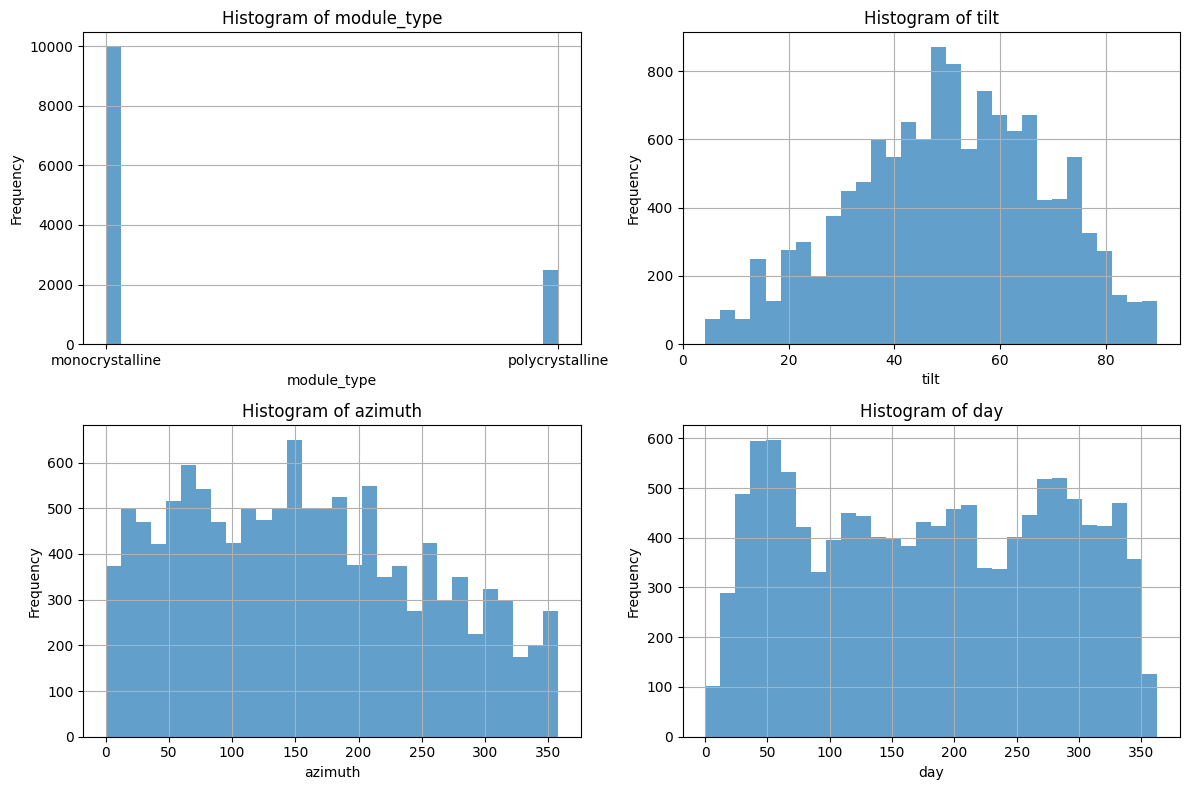

In [ ]:
""" Display the results of the synthetic dataset. """

# Define columns to plot
columns =[ 'module_type','tilt','azimuth','day']
num_columns = len(columns)
num_rows = (num_columns + 1) // 2  

# Create a figure with subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 4))  
axes = axes.flatten()  

# Plot histograms for each column
for i, column in enumerate(columns):
    sa_results[column].hist(ax=axes[i], bins=30, alpha=0.7)  
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    if column == 'gaussian_params':
        axes[i].set_xscale('log')  


# If the number of columns is odd, hide the last subplot (if unused)
if num_columns % 2 != 0:
    fig.delaxes(axes[-1])

fig.tight_layout()
plt.show()